Let's prepare some data:

In [1]:
import statsmodels.api as sm
import pandas as pd
import math
import scipy.stats as st

def bayesian_rating_products(n, confidence=0.95):
    """
    Function to calculate wilson score for N star rating system. 
    :param n: Array having count of star ratings where ith index represent the votes for that category i.e. [3, 5, 6, 7, 10]
    here, there are 3 votes for 1-star rating, similarly 5 votes for 2-star rating. 
    :param confidence: Confidence interval
    :return: Score
    """
    if sum(n)==0:
        return 0
    K = len(n)
    z = st.norm.ppf(1 - (1 - confidence) / 2)
    N = sum(n)
    first_part = 0.0
    second_part = 0.0
    for k, n_k in enumerate(n):
        first_part += (k+1)*(n[k]+1)/(N+K)
        second_part += (k+1)*(k+1)*(n[k]+1)/(N+K)
    score = first_part - z * math.sqrt((second_part - first_part*first_part)/(N+K+1))
    return score

df = pd.read_json("export/data/apps.json").T

df["star_average"] = sum([i*df ["star%d" % i] for i in range(1, 6)]) / sum(([df ["star%d" % i] for i in range(1, 6)]))

df["confidence"] = df.apply(lambda row : bayesian_rating_products([row["star1"], row["star2"], row["star3"], row["star4"], row["star5"]]), axis=1)


In [50]:
reviewsDf = pd.read_json("export/data/reviews.json")

reviewsDf["locale"] = reviewsDf["locale"].str.replace(".UTF-8", "")

reviewsDf["date_created"] = pd.to_datetime(reviewsDf["date_created"], unit="s")

/tmp/ipykernel_12065/1265797920.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  reviewsDf["locale"] = reviewsDf["locale"].str.replace(".UTF-8", "")


,app_id,date_created,description,distro,karma_down,karma_up,locale,rating,reported,review_id,summary,user_display,user_hash,version
0,0ad.desktop,2021-08-19 19:37:49,puto chupa pija el que lo lea,Ubuntu,0,0,es_UY,100,0,411261,mateo,ceibal,a97f371e5db86d366d6d4616dc9c430605131ed0,0.0.22
1,com.play0ad.zeroad,2021-08-19 03:25:43,I was promised Scythians and many other new ci...,Ubuntu,0,0,en_CA,80,0,410981,No Scythians in A25,George,e9a8b3b7245fa6f60640fb626c0e1446f3c7334c,0.0.25-alpha
2,com.play0ad.zeroad,2021-08-13 11:43:58,very bad gamel son t dont download this game,Ubuntu,0,0,en_US,100,0,409083,very bad gamel son t dont download this game,Ali Hamza,1d1e4b4c41b345fa044100c3b4eca58668982732,0.0.23.1
3,com.play0ad.zeroad,2021-08-12 22:31:09,As good if not better than AOE2. I hope develo...,Ubuntu,0,0,en_NZ,100,0,408923,Excellent free game like Age of Empires 2,Michael Lucas,af392a6035dd6ae45032345e9a1f2b1641baf7b0,0.0.25
4,com.play0ad.zeroad,2021-08-12 20:36:03,gggggggggggggggg,Ubuntu,0,0,es_ES,80,0,408875,ggggggggggggg,ceibal,b63b55111b4a52690e4101579b9b5e9c5e783b17,0.0.23.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229980,zynaddsubfx-oss.desktop,2020-01-26 14:22:43,fferzfgtezqrgveg,Ubuntu,2,0,fr_FR,80,0,142377,ezeef,Le Best,4829464c253dba9821a2b7c67ec4901c0186ccd8,3.0.3
229981,zyne.desktop,2020-06-26 05:35:37,Hard to give a review when I couldn't even get...,Ubuntu,0,0,en_US,20,0,237547,Didn't work,Smoke,03a9061fbb8c6e8fca536814a9c3bca423b798d7,0.1.2
229982,zyne.desktop,2019-12-04 12:50:06,intéressant pour qui fait du python,Ubuntu,0,0,fr_FR,100,0,119283,Fonctionne très bien,thil,37aa9e4582405ae05546f73aca8e44565255c025,0.1.2
229983,zyne.desktop,2019-09-05 23:44:13,"Just Improve the Sound & Stereo ,Add Some More...",Ubuntu,0,0,en_US,100,0,80749,Improve it Much More It Will Work,Hawre,1c8f650f3cc3e2d9eaa9e97fc163f0f66c9d3c46,0.1.2


Let's look how apps are rated:

<AxesSubplot:title={'center':'Number of ratings per app'}, ylabel='Number of ratings'>

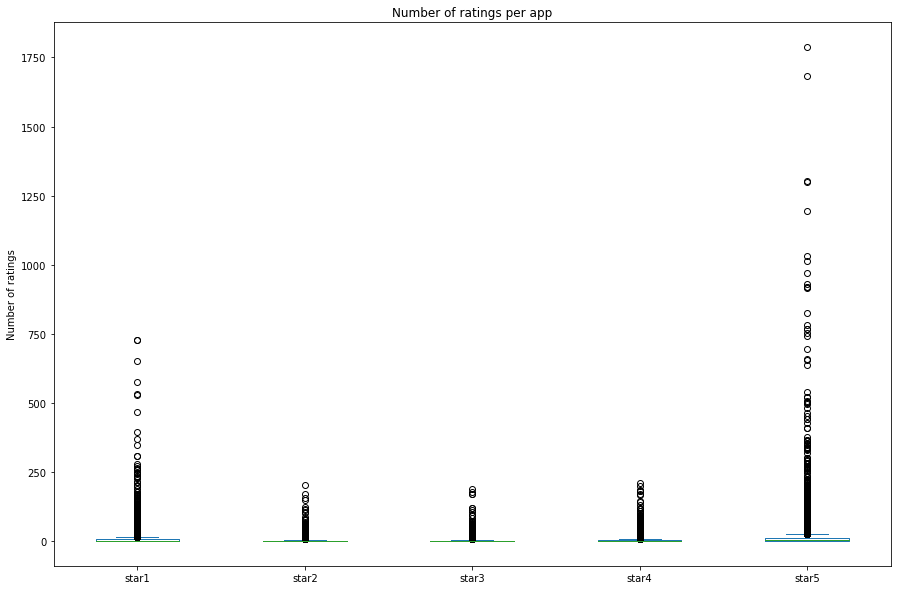

In [3]:
df[["star1", "star2", "star3", "star4", "star5"]].plot.box(title="Number of ratings per app", ylabel="Number of ratings", xlabel="Star rating", figsize=(15, 10))

So it seems like there are far more apps with one stars and five stars then everything else. Not very suprising so far.

So let's look at the raw data and figure out what the mean for each rating is.

<AxesSubplot:title={'center':'Distribution of ratings over all apps'}, xlabel='Star rating', ylabel='Number of ratings'>

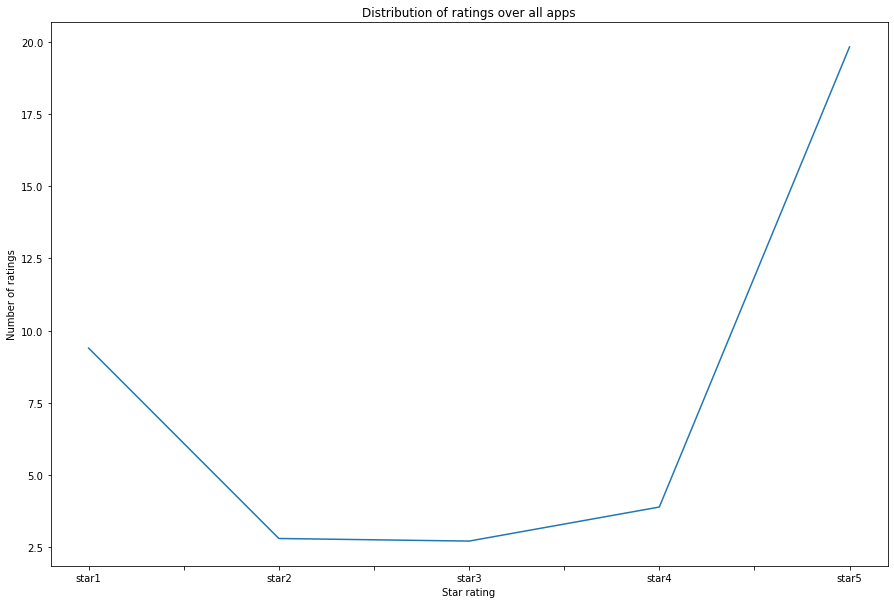

In [4]:
df[["star1", "star2", "star3", "star4", "star5"]].mean().plot(title="Distribution of ratings over all apps", ylabel="Number of ratings", xlabel="Star rating", figsize=(15, 10))

<AxesSubplot:title={'center':'Average number of ratings across all apps'}, ylabel='Rating'>

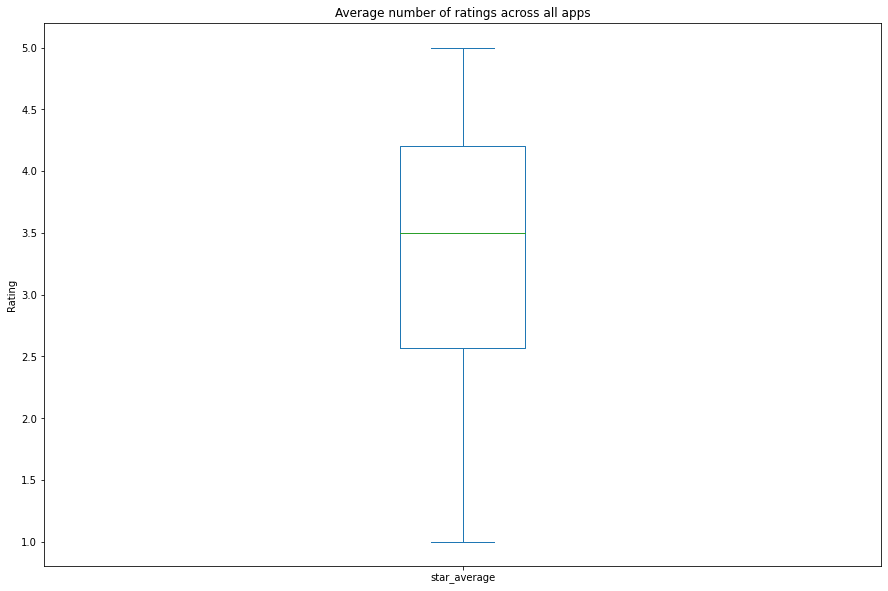

In [5]:
df["star_average"].plot.box(ylabel="Rating", title="Average number of ratings across all apps", figsize=(15, 10))

So the average rating of the apps in the linux ecosystem is around 3.5

Have a look at the top rated apps:

In [6]:
df[df["total"]>20].dropna().nlargest(20,"confidence")[["star_average", "confidence", "total"]]

,star_average,confidence,total
dash-to-panel_jderose9.github.com,4.850829,4.695125,181
code-url-handler.desktop,4.679261,4.618271,1191
org.speedcrunch.SpeedCrunch,4.962963,4.617511,54
speedcrunch.desktop,4.962963,4.617511,54
io.snapcraft.sublime-text-2kOIsSRmQ7zjpIxzZDpoXaZOVejqaGOT,4.698582,4.611051,564
cool-retro-term.desktop,4.752688,4.595825,186
io.snapcraft.cool-retro-term-6d6yw8CVhAYys3Z09b4sGSwzXSWR6btg,4.752688,4.595825,186
code.desktop,4.634879,4.579010,1531
io.snapcraft.code-Ht0aUHi7ofh9Fbwh6m7jUN2pAy6kzBiu,4.633923,4.577920,1527
com.bitwarden.desktop,4.728070,4.572949,228


Which distros are these reviews coming from?

<AxesSubplot:title={'center':'Distribution of reviews per distribution'}>

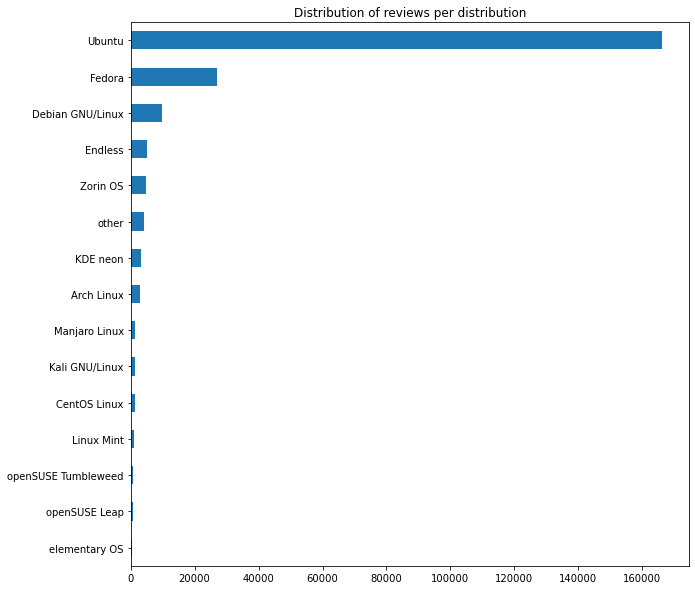

In [7]:
prob_distro = reviewsDf["distro"].value_counts()

mask = prob_distro > 500
tail_prob_distro = prob_distro.loc[~mask].sum()
prob_distro = prob_distro.loc[mask]
prob_distro['other'] = tail_prob_distro
prob_distro.sort_values().plot(kind='barh', figsize=(10, 10), title="Distribution of reviews per distribution")

Which languages are these reviews in?

<AxesSubplot:title={'center':'Distribution of reviews per locale'}>

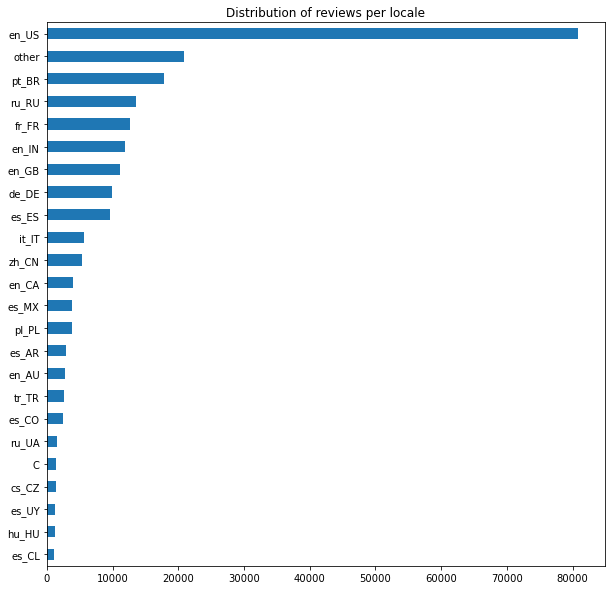

In [8]:
prob_locale = reviewsDf["locale"].value_counts()

mask = prob_locale > 1000
tail_prob_locale = prob_locale.loc[~mask].sum()
prob_locale = prob_locale.loc[mask]
prob_locale['other'] = tail_prob_locale
prob_locale.sort_values().plot(kind='barh', figsize=(10, 10), title="Distribution of reviews per locale")

So how many reviews did the system get per day?

<AxesSubplot:title={'center':'Number of reviews per day'}, xlabel='date_created'>

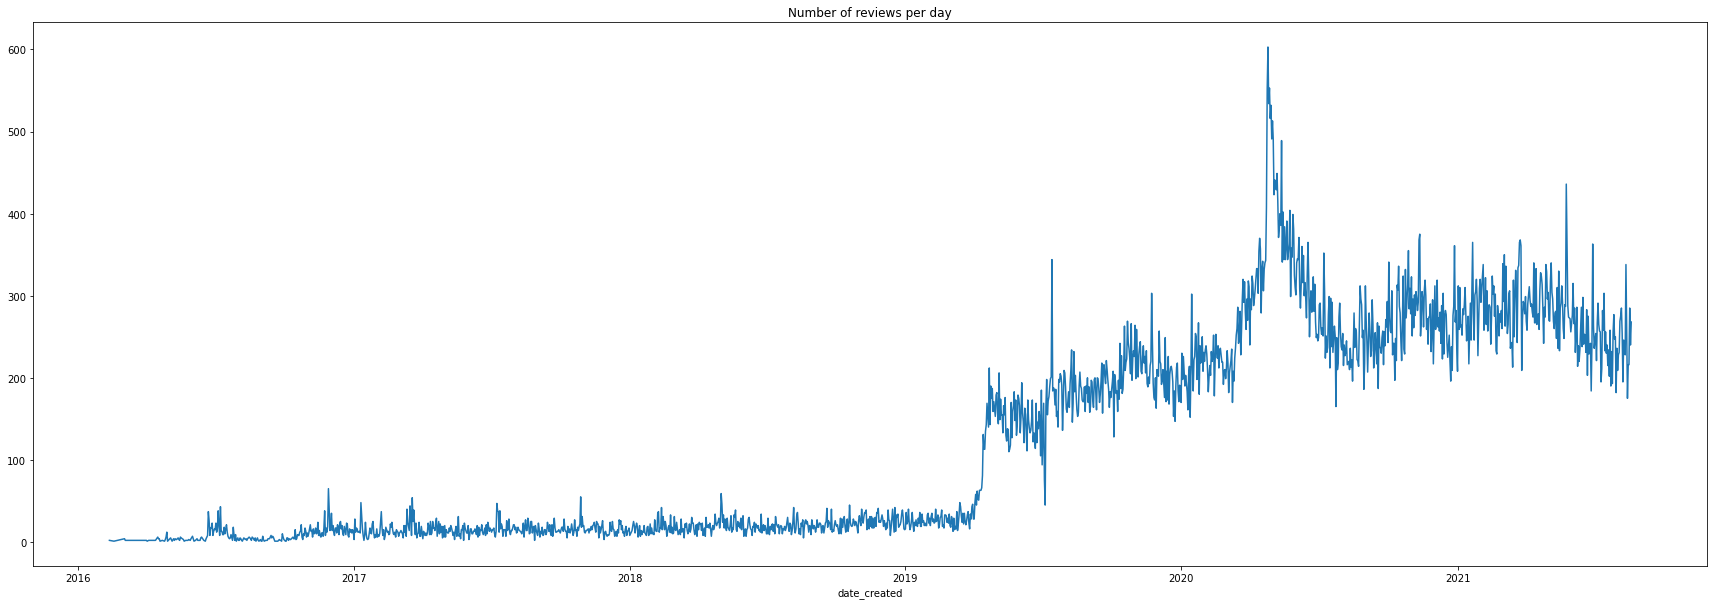

In [9]:
reviewsDf.groupby(reviewsDf['date_created'].dt.date)["date_created"].count().plot(kind='line', figsize=(30, 10), title="Number of reviews per day")

<AxesSubplot:title={'center':'Number of reviews per day per distribution'}, xlabel='date_created'>

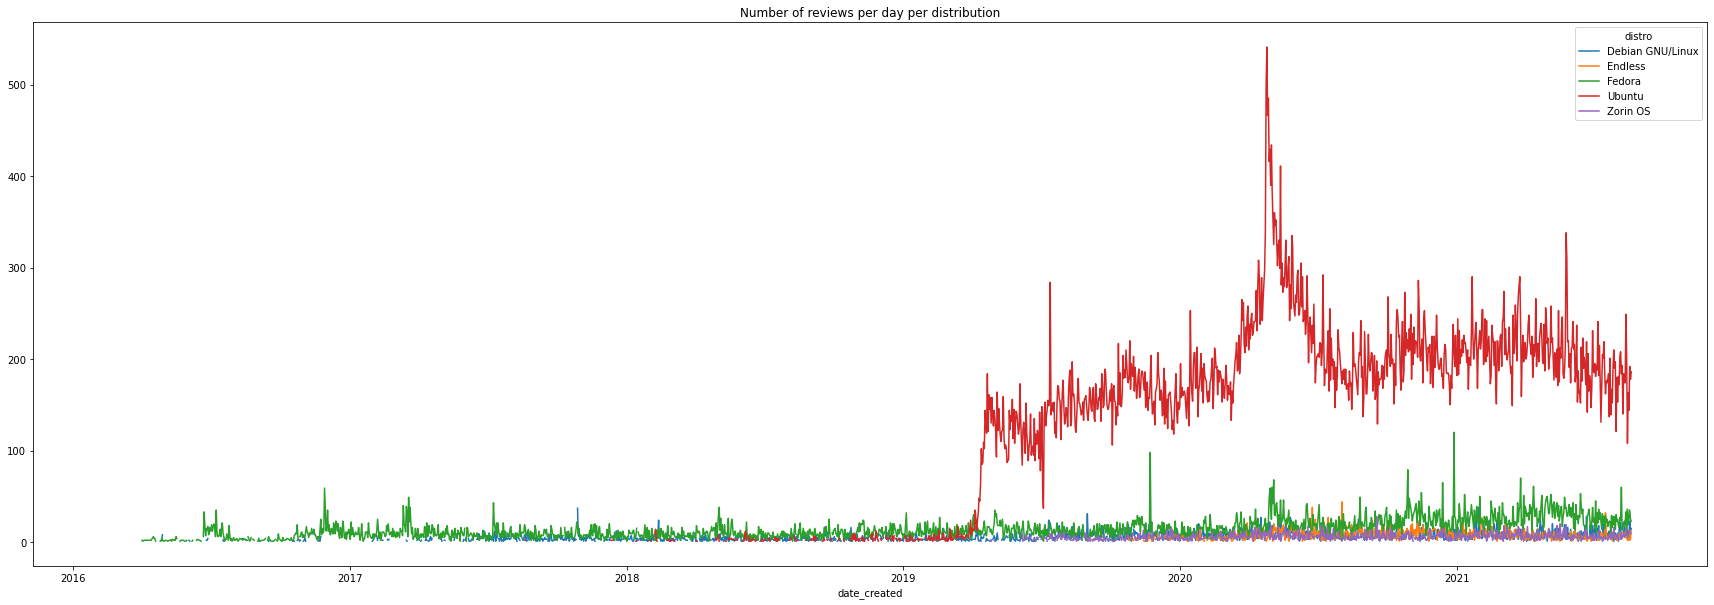

In [86]:
pivot_table = reviewsDf.groupby([reviewsDf["date_created"].dt.date,"distro"])["date_created"].count().unstack()
pivot_table.loc[:,pivot_table.columns.isin(prob_distro.index.map(lambda x: x).tolist()[:5])].plot(kind='line', figsize=(30, 10), title="Number of reviews per day per distribution")

In [12]:
prob_distro.head(5)

Ubuntu              166225
Fedora               27061
Debian GNU/Linux      9796
Endless               4962
Zorin OS              4684
Name: distro, dtype: int64